In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

**Pretraitment**

In [2]:
data = pd.read_csv('enron_spam_data.csv')
data.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [3]:
# Convertir 'Spam/Ham' en 'label' (1 = spam, 0 = ham) et supprimer la colonne originale
data['label'] = data['Spam/Ham'].map({'spam': 1, 'ham': 0})
data.drop(columns=['Spam/Ham'], inplace=True)
data.head()

,Message ID,Subject,Message,Date,label
0,0,christmas tree farm pictures,NaN,1999-12-10,0
1,1,"vastar resources , inc .","gary , production from the high island larger ...",1999-12-13,0
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,1999-12-14,0
3,3,re : issue,fyi - see note below - already done .\nstella\...,1999-12-14,0
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,1999-12-14,0


In [4]:
data.dropna(inplace=True)
print("Nombre de valeur null par colonne :")
print(data.isnull().sum())


Nombre de valeur null par colonne :
Message ID    0
Subject       0
Message       0
Date          0
label         0
dtype: int64


In [5]:
label_counts = data['label'].value_counts()
label_percentages = (label_counts / label_counts.sum()) * 100
table = pd.DataFrame({
    'Count': label_counts,
    'Percentage (%)': label_percentages.map('{:.2f}'.format) 
})
table = table.rename(index={0: 'Ham', 1: 'Spam'})
print("Distribution des emails:")
table


Distribution des emails:


,Count,Percentage (%)
label,,
Spam,16614,50.18
Ham,16493,49.82


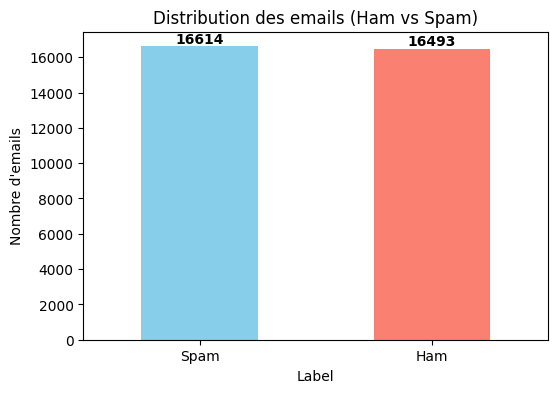

In [6]:
label_counts = data['label'].value_counts()
label_counts.index = ['Spam', 'Ham']

plt.figure(figsize=(6, 4))
ax = label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution des emails (Ham vs Spam)')
plt.xlabel('Label')
plt.ylabel("Nombre d'emails")
plt.xticks(rotation=0)

for i, v in enumerate(label_counts):
    ax.text(i, v + 0.2, str(v), ha='center', va='bottom', fontweight='bold')

plt.show()


In [7]:
# Telechargement des ressources NLTK
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\salah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def pretraitement(text):
    # 1. Conversion en minuscules
    text = text.lower()
    # 2. Suppression des URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # 3. Suppression des adresses email
    text = re.sub(r'\S+@\S+', '', text)
    # 4. Suppression des caracteres non alphabetiques
    text = re.sub(r'[^a-z\s]', '', text)
    # 5. Separation des mots et suppression des stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # 6. Lemmatisation des mots
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [9]:
data['message_traite'] = data['Message'].apply(pretraitement)

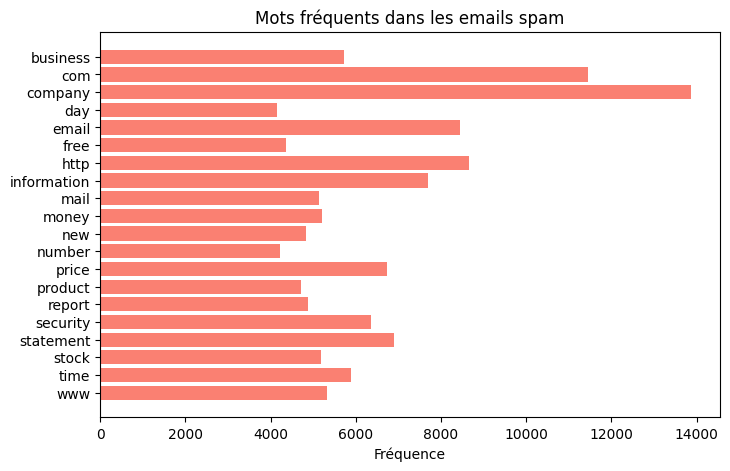

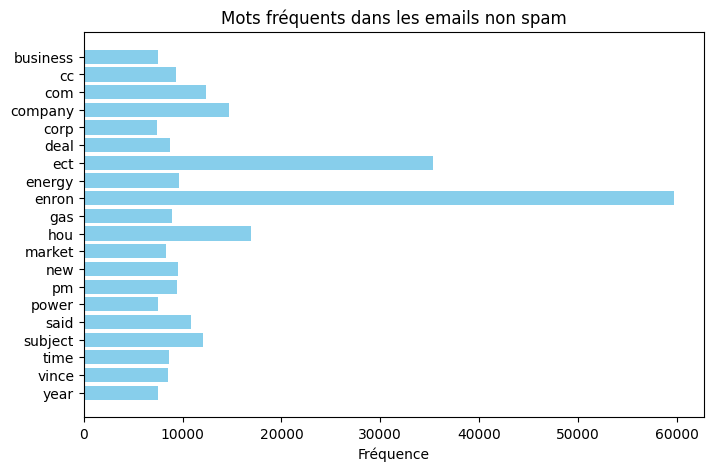

In [10]:
# Extraction des emails spam et non spam
spam_emails = data[data['label'] == 1]['message_traite']
ham_emails = data[data['label'] == 0]['message_traite']

def frequence_des_mots(emails, titre, coulour):
    # Identification des mots les plus frequents
    vectorizer = CountVectorizer(stop_words='english', max_features=20)
    word_counts = vectorizer.fit_transform(emails).toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()
    plt.figure(figsize=(8, 5))
    plt.barh(words, word_counts, color=coulour)
    plt.title(titre)
    plt.xlabel('Fréquence')
    plt.gca().invert_yaxis()
    plt.show()

# Affichage des mots frequents
frequence_des_mots(spam_emails, 'Mots fréquents dans les emails spam', 'salmon')
frequence_des_mots(ham_emails, 'Mots fréquents dans les emails non spam', 'skyblue')

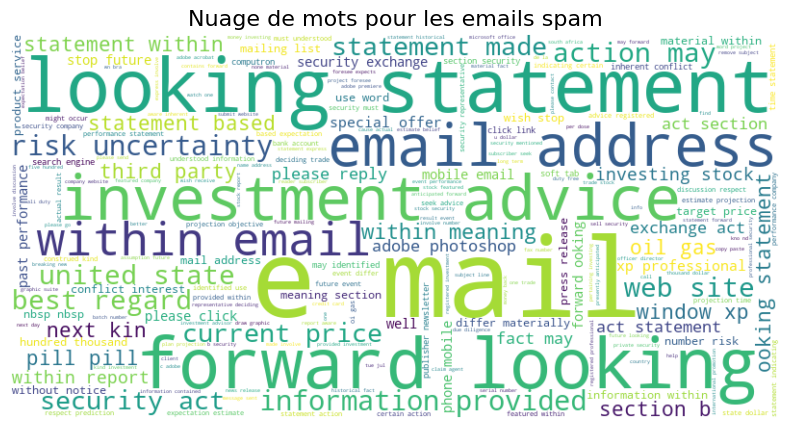

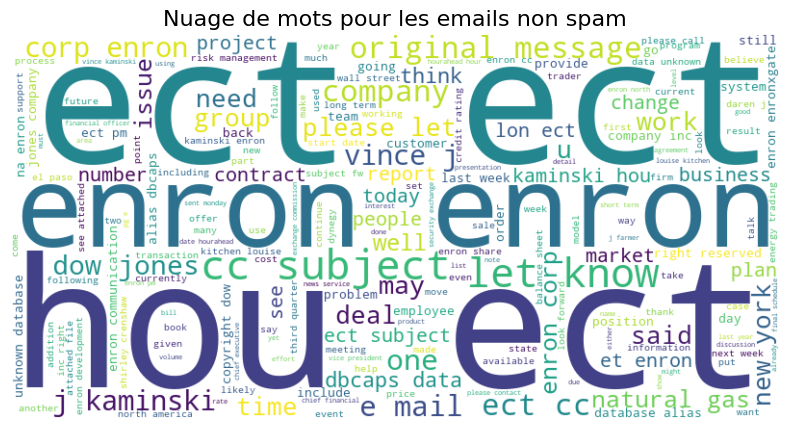

In [11]:
def creation_worldcloud(emails, titre):
    # Generation d'un nuage de mots
    text = ' '.join(emails)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titre, fontsize=16)
    plt.show()

# Affichage des nuages de mots
creation_worldcloud(spam_emails, 'Nuage de mots pour les emails spam')
creation_worldcloud(ham_emails, 'Nuage de mots pour les emails non spam')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data['message_traite'], data['label'], test_size=0.2, random_state=42)
# Creation de la matrice TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

**Entrainement**

**Selection du model**

In [13]:
def afficher_matrice_de_confusion(nom, y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matrice de Confusion - {nom}")
    plt.show()

Entraînement du modèle Naive Bayes...


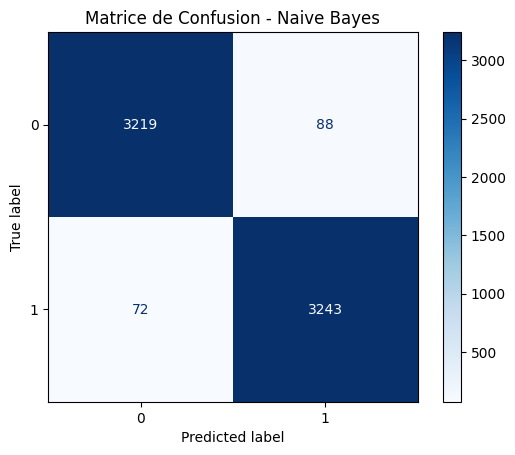

Entraînement du modèle Random Forest...


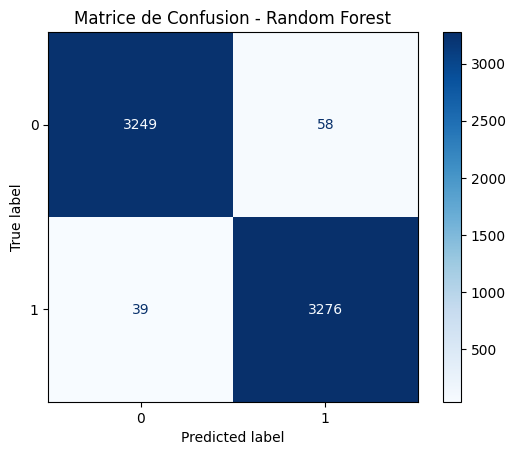

Entraînement du modèle Regression Logistique...


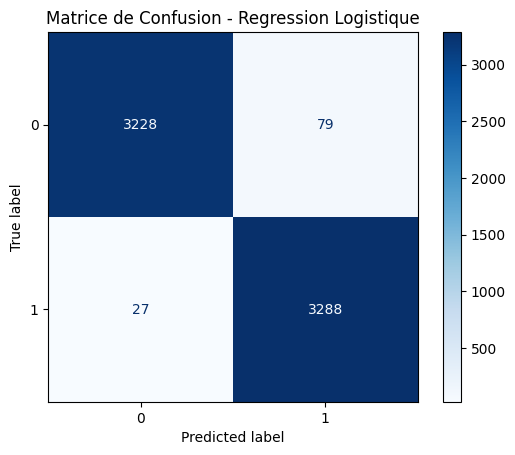

Entraînement du modèle SVM...


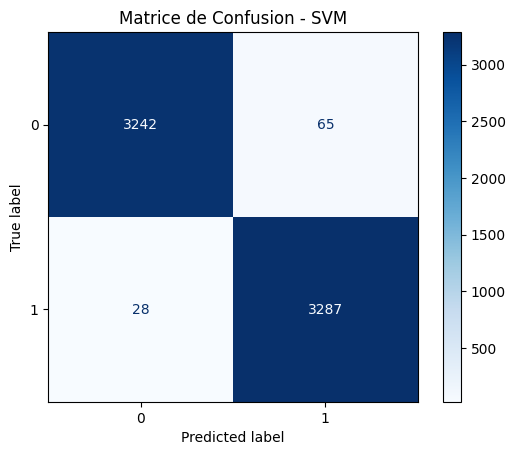

,Modele,Accuracy,Precision,Recall,F1-Score,AUC
0,Naive Bayes,0.975838,0.973582,0.978281,0.975925,0.997100
1,Random Forest,0.985352,0.982603,0.988235,0.985411,0.998358
2,Regression Logistique,0.983993,0.976537,0.991855,0.984136,0.998494
3,SVM,0.985956,0.980609,0.991554,0.986051,0.998604


In [14]:
# Dictionnaire des classifieurs
classifieurs = {
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Regression Logistique": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42, probability=True)  
}
resultats = []
# Entrainement et evaluation pout chaque classifieur
for nom, modele in classifieurs.items():
    print(f"Entraînement du modèle {nom}...")
    modele.fit(X_train_tfidf, y_train)
    # Predictions
    y_pred = modele.predict(X_test_tfidf)
    y_pred_proba = modele.predict_proba(X_test_tfidf)[:, 1]  
    # Calcule des metriques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    resultats.append({
        'Modele': nom,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    })
    # Affichage de la matrice de confusion
    afficher_matrice_de_confusion(nom, y_test, y_pred, modele.classes_)


df_resultats = pd.DataFrame(resultats)
df_resultats

In [15]:
grille_hyperparametres_rf = {
    'n_estimators': [50, 100, 200],  # Nombre d'arbres dans la foret
    'max_depth': [None, 10, 20, 30],  # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10],  # Nombre minimal d'echantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 4]  # Nombre minimal d'echantillons dans une feuille
}

rf = RandomForestClassifier(random_state=42)
# Effectuer la recherche par grille pour le Random Forest
recherche_grille_rf = GridSearchCV(
    estimator=rf,
    param_grid=grille_hyperparametres_rf,
    scoring='accuracy',  
    cv=5,  
    n_jobs=-1  
)
recherche_grille_rf.fit(X_train_tfidf, y_train)
# Sauvegarder le meilleur modele
meilleur_rf = recherche_grille_rf.best_estimator_
# Afficher les meilleurs hyperparametres et le score correspondant
print(f"Meilleurs hyperparamètres pour Random Forest: {recherche_grille_rf.best_params_}")
print(f"Meilleure précision (accuracy) pour Random Forest: {recherche_grille_rf.best_score_:.4f}")

In [16]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)
print("Modèle Random Forest")
print("Précision:", accuracy_score(y_test, y_pred_rf))
print("Rappel: ",recall_score(y_test, y_pred_rf))

Modèle Random Forest
Précision: 0.9853518574448807
Rappel:  0.9882352941176471


**Sauvegarder le modele**

In [17]:
# Sauvegarde des modèles
joblib.dump(rf_model, 'spam_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']